
# Project 1 — Parts c)–f)
This notebook solves **c, d, e, f**. 


In [91]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (new variables added on as they are introduced) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
LAM  = 1e-4   # from part b
#LAM = 1      # Bigger lambda to see convergence in plots ? --- IGNORE ---
BETA = 0.3   # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

Xtr_p = X_tr_s[:, :P_FIXED]
Xte_p = X_te_s[:, :P_FIXED]
p = Xtr_p.shape[1]
theta0 = np.zeros(p)


## c) Gradient Descent for OLS and Ridge (using `grad.py`)

We first use the plain gradient descent method and compare it to close form OLS and Ridge. This is based off an example from the lecture notes, week 37, Gradient Descent Example. 


In [92]:
# ---- closed forms and metrics ----
from Code.models  import fit_ols, fit_ridge, predict_centered
from Code.metrics import mse, r2
from Code.grad   import loss_ridge, loss_ols

n, p = Xtr_p.shape
XT_X_tr = Xtr_p.T @ Xtr_p

theta_cf_ols   = fit_ols(Xtr_p, y_tr_c)                  # solves (X^T X)θ = X^T y_c
theta_cf_ridge = fit_ridge(Xtr_p, y_tr_c, lam=LAM, n_factor=True)  # solves (X^T X + λ I)θ = X^T y_c

# ---- Hessians  ----
# OLS objective: (1/2n)||Xθ - y_c||^2  ⇒ H = (X^T X)/n
# Ridge objective (λ-form): (1/2n)||Xθ - y_c||^2 + (λ/2)||θ||^2  ⇒ H = (X^T X)/n + λ I
H_ols   = XT_X_tr / n
H_ridge = XT_X_tr / n + LAM * np.eye(p)

# Safe steps, based on largest Hessian eigenvalue
L_ols   = np.linalg.eigvalsh(H_ols).max()
L_ridge = np.linalg.eigvalsh(H_ridge).max()
eta_ols   = 1.0 / L_ols
eta_ridge = 1.0 / L_ridge

# Small-but-reasonable iteration budgets for a quick demo (to get close to CF we need more (probably millions), but the code will never finish)
N_ols, N_ridge = 20_000, 20_000  # increase if we want them closer to CF

# ---- plain GD loops (λ-form) ----
def gd_full(X, y_c, lam, eta, iters):
    n, p = X.shape
    th = np.zeros(p)
    for _ in range(iters): # could add a tol-based stopping criterion
        r = X @ th - y_c
        grad = (X.T @ r)/n + lam * th
        th  -= eta * grad
    return th

theta_gd_ols   = gd_full(Xtr_p, y_tr_c, lam=0.0,  eta=eta_ols,   iters=N_ols)
theta_gd_ridge = gd_full(Xtr_p, y_tr_c, lam=LAM, eta=eta_ridge, iters=N_ridge)

# ---- test metrics (on original y-scale) ----
yhat_cf_ols   = predict_centered(Xte_p, theta_cf_ols,   y_mean)
yhat_gd_ols   = predict_centered(Xte_p, theta_gd_ols,   y_mean)
yhat_cf_ridge = predict_centered(Xte_p, theta_cf_ridge, y_mean)
yhat_gd_ridge = predict_centered(Xte_p, theta_gd_ridge, y_mean)

print("OLS   | CF  MSE/R2:", mse(y_te, yhat_cf_ols),   r2(y_te, yhat_cf_ols))
print("OLS   | GD  MSE/R2:", mse(y_te, yhat_gd_ols),   r2(y_te, yhat_gd_ols))
print("Ridge | CF  MSE/R2:", mse(y_te, yhat_cf_ridge), r2(y_te, yhat_cf_ridge))
print("Ridge | GD  MSE/R2:", mse(y_te, yhat_gd_ridge), r2(y_te, yhat_gd_ridge))

print("Ridge TRAIN | CF:", loss_ridge(Xtr_p, y_tr_c, theta_cf_ridge, LAM, True),
      " GD:",           loss_ridge(Xtr_p, y_tr_c, theta_gd_ridge,   LAM, True))

print("OLS TRAIN | CF:", loss_ols(Xtr_p, y_tr_c, theta_cf_ols),
      " GD:",           loss_ols(Xtr_p, y_tr_c, theta_gd_ols))


OLS   | CF  MSE/R2: 0.1351492510020802 0.32147733207080154
OLS   | GD  MSE/R2: 0.13157938981980613 0.33939997474601846
Ridge | CF  MSE/R2: 0.12625328341116895 0.36613992264264184
Ridge | GD  MSE/R2: 0.13217029593648208 0.33643330499528123
Ridge TRAIN | CF: 0.04251260724044948  GD: 0.045991068261716436
OLS TRAIN | CF: 0.04014885485646233  GD: 0.04587079678167183



## d) Optimizers: Momentum, AdaGrad, RMSProp, Adam

We keep the same objectives but change the update rule. We'll use both Ridge and OLS. We plot MSE and R^2 for all the optimizers, and also a training loss plot.  



 TEST metrics by optimizer (OLS)
gd         MSE=0.132044  R²=0.3371
momentum   MSE=0.132044  R²=0.3371
adagrad    MSE=0.137117  R²=0.3116
rmsprop    MSE=0.130348  R²=0.3456
adam       MSE=0.128056  R²=0.3571

 TEST metrics by optimizer (Ridge)
gd         MSE=0.131033  R²=0.3421
momentum   MSE=0.131375  R²=0.3404
adagrad    MSE=0.137484  R²=0.3098
rmsprop    MSE=0.131679  R²=0.3389
adam       MSE=0.130480  R²=0.3449


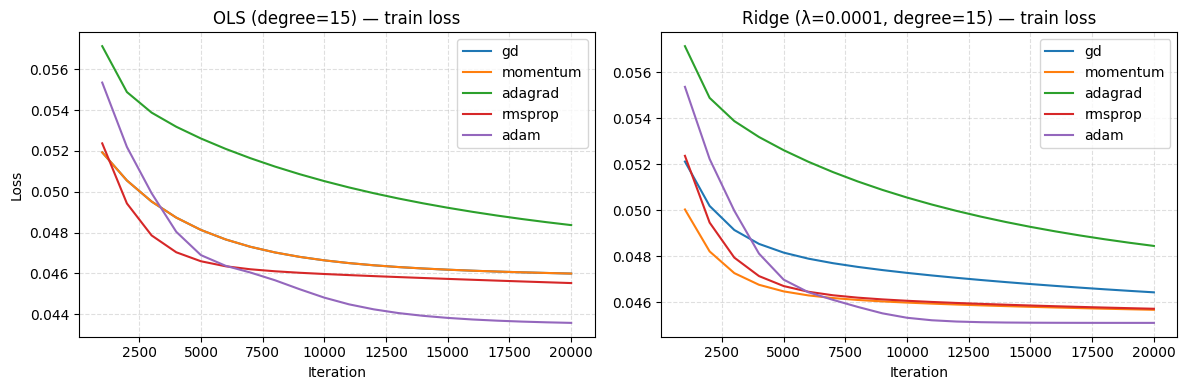

In [93]:
# ---- various optimizers ----

# near-optimal ridge step (helps plain GD/momentum on ridge)
eigs_data = np.linalg.eigvalsh(XT_X_tr / n)
e_min, e_max = eigs_data[0], eigs_data[-1]
ETA_RIDGE_OPT = 2.0 / ((e_max + LAM) + (e_min + LAM))  # = 2/(L+mu) for ridge quad

LOG_EVERY = 1000 # log train loss every this many iters

# Optimizer loop (λ-form objective)
def run_optimizer_lambda(
    X, y_c, lam, *, optimizer="gd", eta=1e-3, iters=20_000,
    beta=BETA, rho=RHO, b1=B1, b2=B2, eps=EPS, log_every=LOG_EVERY
):
    """
    One-loop trainer on the λ-form objective:
      J(θ) = (1/(2n))||Xθ - y_c||^2 + (λ/2)||θ||^2
    Returns (theta, steps, losses) with losses logged every `log_every` iters.
    """
    n, p = X.shape
    th = np.zeros(p)
    v  = np.zeros_like(th)  # momentum velocity
    s  = np.zeros_like(th)  # 2nd moment (AdaGrad/RMSProp/Adam)
    m  = np.zeros_like(th)  # 1st moment (Adam)

    
    steps, losses = [], []
    for k in range(1, iters + 1): 
        r = X @ th - y_c
        g = (X.T @ r) / n + lam * th  # λ-form gradient
        
        if optimizer == "gd":
            th -= eta * g
        elif optimizer == "momentum":
            v  = beta * v + (1 - beta) * g
            th -= eta * v
        elif optimizer == "adagrad":
            s += g * g
            th -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "rmsprop":
            s  = rho * s + (1 - rho) * (g * g)
            th -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "adam":
            m  = b1 * m + (1 - b1) * g
            s  = b2 * s + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**k)
            s_hat = s / (1 - b2**k)
            th -= eta * m_hat / (np.sqrt(s_hat) + eps)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")
        
        #log train loss
        if (k % log_every) == 0:
            L = loss_ols(X, y_c, th) if lam == 0.0 else loss_ridge(X, y_c, th, lam, n_factor=True) 
            steps.append(k); losses.append(float(L)) 

    return th, np.array(steps), np.array(losses)

# iteration budgets
iters_ols, iters_ridge = N_ols, N_ridge

# learning-rate choices: curvature-aware for GD/momentum; conservative bases for adaptives
configs = {
    "gd":       {"ols_eta": 0.8 * eta_ols,   "ridge_eta": ETA_RIDGE_OPT},
    "momentum": {"ols_eta": 0.8 * eta_ols,   "ridge_eta": ETA_RIDGE_OPT, "beta": BETA},
    "adagrad":  {"ols_eta": 1e-2,            "ridge_eta": 1e-2},
    "rmsprop":  {"ols_eta": 1e-3,            "ridge_eta": 1e-3, "rho": RHO},
    "adam":     {"ols_eta": 1e-3,            "ridge_eta": 1e-3, "b1": B1, "b2": B2, "eps": EPS},
}


rows_ols, rows_ridge = [], []
curves_ols, curves_ridge = {}, {}


for name, hp in configs.items():
    # OLS
    th_o, st_o, ls_o = run_optimizer_lambda(
        Xtr_p, y_tr_c, lam=0.0, optimizer=name,
        eta=hp["ols_eta"], iters=iters_ols,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS)
    )
    yhat_o = predict_centered(Xte_p, th_o, y_mean)
    rows_ols.append((name, mse(y_te, yhat_o), r2(y_te, yhat_o)))
    curves_ols[name] = (st_o, ls_o)

    # Ridge
    th_r, st_r, ls_r = run_optimizer_lambda(
        Xtr_p, y_tr_c, lam=LAM, optimizer=name,
        eta=hp["ridge_eta"], iters=iters_ridge,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS)
    )
    yhat_r = predict_centered(Xte_p, th_r, y_mean)
    rows_ridge.append((name, mse(y_te, yhat_r), r2(y_te, yhat_r)))
    curves_ridge[name] = (st_r, ls_r)

print("\n TEST metrics by optimizer (OLS)")
for name, m, r in rows_ols:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

print("\n TEST metrics by optimizer (Ridge)")
for name, m, r in rows_ridge:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

# ---------- loss curves ----------
Lref_ols   = loss_ols(Xtr_p, y_tr_c, theta_cf_ols)
Lref_ridge = loss_ridge(Xtr_p, y_tr_c, theta_cf_ridge, LAM, n_factor=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# OLS
for name, (steps, losses) in curves_ols.items():
    if losses.size:
        axes[0].plot(steps, losses, label=name)
axes[0].set_title(f"OLS (degree={p}) — train loss"); axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Loss")
axes[0].grid(True, ls="--", alpha=0.4); axes[0].legend()

# Ridge
for name, (steps, losses) in curves_ridge.items():
    if losses.size:
        axes[1].plot(steps, losses, label=name)
axes[1].set_title(f"Ridge (λ={LAM:g}, degree={p}) — train loss"); axes[1].set_xlabel("Iteration")
axes[1].grid(True, ls="--", alpha=0.4); axes[1].legend()

savepath = fig_dir / "Part_c_d_e_f_GD_optimizers_loss_curves.png"
fig.savefig(savepath, dpi=150)
fig.tight_layout(); plt.show()



## e) LASSO 

GD Lasso vs Scikit Lasso. 



In [94]:
def soft_threshold(z, tau):
    # elementwise shrinkage: sign(z)*max(|z|-tau, 0)
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

#lasso via iterative soft-thresholding (ISTA)
def lasso_ista(X, y_c, theta0, eta, lam, iters):
    """
    Minimizes: (1/n)||Xθ - y_c||^2 + lam * ||θ||_1
    Proximal step matches sklearn if you set alpha = lam/2 there.
    """
    n = X.shape[0]
    theta = theta0.copy()
    for _ in range(iters):
        grad = (2.0/n) * (X.T @ (X @ theta - y_c))     # gradient of (1/n)||r||^2
        theta = soft_threshold(theta - eta*grad, eta*lam)
    return theta

from Code.models import fit_lasso_skl #Scikit-learn Lasso
""" from Code.grad import lasso_gd, lasso_ista """

# --- Compare LASSO: scikit vs. GD at λ=LAM---
lam = LAM #use same lambda as ridge for simplicity

# sklearn baseline (coordinate descent)
theta_skl = fit_lasso_skl(Xtr, y_tr_c, lam)

# proximal gradient (ISTA)
theta0 = np.zeros(Xtr.shape[1])
theta_pg = lasso_ista(Xtr, y_tr_c, theta0, eta=1e-3, lam=lam, iters=5000)

# predictions (remember + y_mean)
yhat_skl = Xte @ theta_skl + y_mean
yhat_pg  = Xte @ theta_pg  + y_mean

print("SKL  MSE/R²:", mse(y_te, yhat_skl), r2(y_te, yhat_skl))
print("ISTA MSE/R²:", mse(y_te, yhat_pg),  r2(y_te, yhat_pg))




SKL  MSE/R²: 0.12913859860045612 0.351654072772696
ISTA MSE/R²: 0.15378708005216485 0.22790530412610277


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+00, tolerance: 4.234e-05
  model = cd_fast.enet_coordinate_descent(


We add the optimizers from part d). 

In [95]:
# --- Proximal optimizers for Lasso (1/n)||Xθ - y_c||^2 + λ||θ||_1 ---
def soft_threshold(z, tau): 
    # tau can be scalar or per-coordinate array
    return np.sign(z) * np.maximum(np.abs(z) - tau, 0.0)

 # Gradient of the smooth part of Lasso: (1/n)||Xθ - y_c||^2
def grad_smooth_lasso(X, y_c, theta):
    # gradient of (1/n)||Xθ - y_c||^2
    n = X.shape[0]
    return (2.0/n) * (X.T @ (X @ theta - y_c))

# Proximal optimizers for Lasso
def run_prox_optimizer_lasso(
    X, y_c, lam, optimizer="pgd",
    eta=1e-3, iters=5000,
    beta=0.9,           # momentum / FISTA
    rho=0.99,           # RMSProp
    b1=0.9, b2=0.999,   # Adam
    eps=1e-8,           #epsilon means 
    theta0=None,  
    nesterov=True       # for FISTA
):
    """
    Proximal optimizers for Lasso:
      - 'pgd'    : proximal GD (ISTA)
      - 'fista'  : accelerated proximal GD (Nesterov)
      - 'adagrad': proximal AdaGrad
      - 'rmsprop': proximal RMSProp
      - 'adam'   : proximal Adam 

    All use scaling: (1/n)||Xθ - y||^2 + lam * ||θ||_1
    """
    p = X.shape[1]
    theta = np.zeros(p) if theta0 is None else np.asarray(theta0, float).copy()

    # state for adaptive methods / momentum
    s_adagrad = np.zeros(p)
    v_rms     = np.zeros(p)
    m_adam    = np.zeros(p)
    v_adam    = np.zeros(p)
    t = 0

    # FISTA variables
    yk = theta.copy()
    tk = 1.0

    for _ in range(iters):
        t += 1

        # choose the point to evaluate the gradient at (FISTA uses yk, others use theta)
        if optimizer == "fista":
            grad = grad_smooth_lasso(X, y_c, yk)
        else:
            grad = grad_smooth_lasso(X, y_c, theta)

        if optimizer == "pgd":  # ISTA
            step = eta                       # scalar step
            theta = soft_threshold(theta - step * grad, lam * step)

        elif optimizer == "fista":
            step = eta
            z = yk - step * grad
            theta_next = soft_threshold(z, lam * step)
            if nesterov:
                tk_next = 0.5 * (1 + np.sqrt(1 + 4 * tk * tk))
                yk = theta_next + ((tk - 1) / tk_next) * (theta_next - theta)
                tk = tk_next
                theta = theta_next
            else:
                theta = theta_next

        elif optimizer == "adagrad":
            s_adagrad += grad * grad
            step_i = eta / (np.sqrt(s_adagrad) + eps)  # element-wise
            theta = soft_threshold(theta - step_i * grad, lam * step_i)

        elif optimizer == "rmsprop":
            v_rms = rho * v_rms + (1 - rho) * (grad * grad)
            step_i = eta / (np.sqrt(v_rms) + eps)      # element-wise
            theta = soft_threshold(theta - step_i * grad, lam * step_i)

        elif optimizer == "adam":
            m_adam = b1 * m_adam + (1 - b1) * grad
            v_adam = b2 * v_adam + (1 - b2) * (grad * grad)
            m_hat = m_adam / (1 - b1**t)
            v_hat = v_adam / (1 - b2**t)
            step_i = eta / (np.sqrt(v_hat) + eps)      # element-wise effective step
            theta = soft_threshold(theta - step_i * m_hat, lam * step_i)

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

    return theta


In [96]:
"""Helpers for Lasso experiments
"""
Xtr, Xte = Xtr_p, Xte_p
# safe step for ISTA / FISTA:
n = Xtr.shape[0]
smax = np.linalg.svd(Xtr, compute_uv=False)[0] # largest singular value
L = (2.0/n) * (smax**2) # Lipschitz constant of ∇f
ETA_ISTA = 1.0 / L # safe step for ISTA / FISTA


In [97]:
# Configs for different optimizers, we can't use the same eta for all optimizers, need a smaller eta for the optimizers that 
# are more "aggressive" (like Adam and RMSProp)
cfgs = {
    "pgd":    dict(eta=ETA_ISTA, iters=5000),
    "fista":  dict(eta=ETA_ISTA, iters=3000, beta=0.0),  # beta unused; nesterov=True inside
    "adagrad":dict(eta=1e-2,     iters=5000),
    "rmsprop":dict(eta=1e-3,     iters=5000, rho=RHO),
    "adam":   dict(eta=1e-3,     iters=5000, b1=B1, b2=B2),
}


In [98]:

lam = LAM

# sklearn baseline (coordinate descent)
theta_skl = fit_lasso_skl(Xtr, y_tr_c, lam)

# proximal optimizers
theta_pgd   = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="pgd",   **cfgs["pgd"])
theta_fista = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="fista", **cfgs["fista"])
theta_rms   = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="rmsprop", **cfgs["rmsprop"])
theta_adam  = run_prox_optimizer_lasso(Xtr, y_tr_c, lam, optimizer="adam", **cfgs["adam"])

# predictions (+ y_mean)
yhat_skl   = Xte @ theta_skl   + y_mean
yhat_pgd   = Xte @ theta_pgd   + y_mean
yhat_fista = Xte @ theta_fista + y_mean
yhat_rms   = Xte @ theta_rms   + y_mean
yhat_adam  = Xte @ theta_adam  + y_mean


print("ISTA  MSE/R²:", mse(y_te, yhat_pg),    r2(y_te, yhat_pg))
print("SKL   MSE/R²:", mse(y_te, yhat_skl),   r2(y_te, yhat_skl))
print("PGD   MSE/R²:", mse(y_te, yhat_pgd),   r2(y_te, yhat_pgd))
print("FISTA MSE/R²:", mse(y_te, yhat_fista), r2(y_te, yhat_fista))
print("RMSPr MSE/R²:", mse(y_te, yhat_rms),   r2(y_te, yhat_rms))
print("Adam  MSE/R²:", mse(y_te, yhat_adam),  r2(y_te, yhat_adam))


/Users/selmabeateovland/Documents/Fys-stk4155/Oppgaver og prosjekt/Project1/FYS-STK4155/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e+00, tolerance: 4.234e-05
  model = cd_fast.enet_coordinate_descent(


ISTA  MSE/R²: 0.15378708005216485 0.22790530412610277
SKL   MSE/R²: 0.12913859860045612 0.351654072772696
PGD   MSE/R²: 0.13712411356944226 0.31156244902065877
FISTA MSE/R²: 0.12873283597248183 0.35369122161989763
RMSPr MSE/R²: 0.13419500136327753 0.3262681837106741
Adam  MSE/R²: 0.13377767634299617 0.3283633820492172



## f) Stochastic Gradient Descent

We test SGD on Ridge. We test with different batch sizes, and plot loss vs epochs for plain GD and SGD. We evaluate with MSE and $R^2$. 




 TEST metrics by optimizer (OLS)
gd         MSE=0.132044  R²=0.3371
momentum   MSE=0.132044  R²=0.3371
adagrad    MSE=0.137117  R²=0.3116
rmsprop    MSE=0.130348  R²=0.3456
adam       MSE=0.128056  R²=0.3571
sgd        MSE=0.160548  R²=0.1940

 TEST metrics by optimizer (Ridge)
gd         MSE=0.131033  R²=0.3421
momentum   MSE=0.131375  R²=0.3404
adagrad    MSE=0.137484  R²=0.3098
rmsprop    MSE=0.131679  R²=0.3389
adam       MSE=0.130480  R²=0.3449
sgd        MSE=0.155666  R²=0.2185


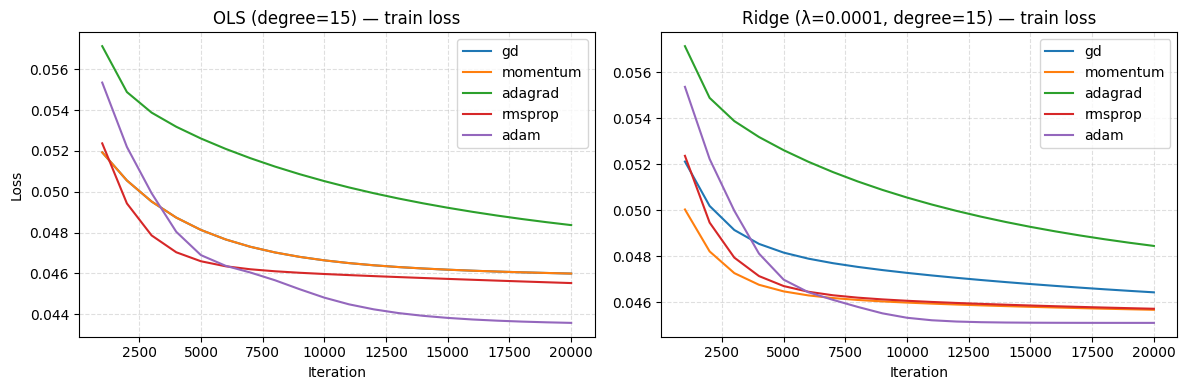

In [ ]:
# ---- various optimizers + SGD ----

# near-optimal ridge step (helps plain GD/momentum on ridge)
eigs_data = np.linalg.eigvalsh(XT_X_tr / n)
e_min, e_max = eigs_data[0], eigs_data[-1]
ETA_RIDGE_OPT = 2.0 / ((e_max + LAM) + (e_min + LAM))  # = 2/(L+mu) for ridge quad

LOG_EVERY = 1000 # log train loss every this many iters

# Optimizer loop (λ-form objective)
def run_optimizer_lambda(
    X, y_c, lam, *, optimizer="gd", eta=1e-3, iters=20_000,
    beta=BETA, rho=RHO, b1=B1, b2=B2, eps=EPS, log_every=LOG_EVERY,
    batch_size=None, rng=None
):
    """
    One-loop trainer on the λ-form objective:
      J(θ) = (1/(2n))||Xθ - y_c||^2 + (λ/2)||θ||^2
    Returns (theta, steps, losses) with losses logged every `log_every` iters.
    - For optimizer=="sgd", uses mini-batches of size `batch_size` (required).
    """
    n, p = X.shape
    th = np.zeros(p)
    v  = np.zeros_like(th)  # momentum velocity
    s  = np.zeros_like(th)  # 2nd moment (AdaGrad/RMSProp/Adam)
    m  = np.zeros_like(th)  # 1st moment (Adam)

    steps, losses = [], []
    use_sgd = (optimizer == "sgd")
    if use_sgd and (batch_size is None or rng is None):
        raise ValueError("For optimizer='sgd', please provide batch_size and rng.")

    for k in range(1, iters + 1):
        if use_sgd:
            idx = rng.integers(0, n, size=batch_size)
            Xb  = X[idx]
            yb  = y_c[idx]
            nb  = Xb.shape[0]
            # mini-batch gradient (λ-form)
            g = (Xb.T @ (Xb @ th - yb))/nb + lam * th
        else:
            # full-batch gradient (λ-form)
            r = X @ th - y_c
            g = (X.T @ r) / n + lam * th

        if optimizer in ("gd", "sgd"):
            th -= eta * g
        elif optimizer == "momentum":
            v  = beta * v + (1 - beta) * g
            th -= eta * v
        elif optimizer == "adagrad":
            s += g * g
            th -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "rmsprop":
            s  = rho * s + (1 - rho) * (g * g)
            th -= (eta / (np.sqrt(s) + eps)) * g
        elif optimizer == "adam":
            t  = k  # bias-correction uses step count
            m  = b1 * m + (1 - b1) * g
            s  = b2 * s + (1 - b2) * (g * g)
            m_hat = m / (1 - b1**t)
            s_hat = s / (1 - b2**t)
            th -= eta * m_hat / (np.sqrt(s_hat) + eps)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

   
        # so sgd comes in the plot ? 
        if (k % log_every) == 0 or (k == iters):
            L = loss_ols(X, y_c, th) if lam == 0.0 else loss_ridge(X, y_c, th, lam, n_factor=True)
            steps.append(k); losses.append(float(L))


    return th, np.array(steps), np.array(losses)


# iteration budgets
iters_ols, iters_ridge = N_ols, N_ridge

# --- SGD setup (mini-batch) ---
rng = np.random.default_rng(SEED_MB)
ITERS_SGD = EPOCHS_MB * int(np.ceil(n / BATCH_SIZE))  # steps = epochs × batches/epoch
_batches_per_epoch = int(np.ceil(n / BATCH_SIZE))
print(f"[SGD setup] epochs={EPOCHS_MB}, batch_size={BATCH_SIZE}, "
      f"batches/epoch={_batches_per_epoch}, total_updates={ITERS_SGD}, "
      f"effective_passes≈{ITERS_SGD * BATCH_SIZE / n:.2f}")

# learning-rate choices: curvature-aware for GD/momentum; conservative bases for adaptives
configs = {
    "gd":       {"ols_eta": 0.8 * eta_ols,   "ridge_eta": ETA_RIDGE_OPT},
    "momentum": {"ols_eta": 0.8 * eta_ols,   "ridge_eta": ETA_RIDGE_OPT, "beta": BETA},
    "adagrad":  {"ols_eta": 1e-2,            "ridge_eta": 1e-2},
    "rmsprop":  {"ols_eta": 1e-3,            "ridge_eta": 1e-3, "rho": RHO},
    "adam":     {"ols_eta": 1e-3,            "ridge_eta": 1e-3, "b1": B1, "b2": B2, "eps": EPS},
    "sgd":      {"ols_eta": 0.5 * eta_ols,   "ridge_eta": 0.5 * ETA_RIDGE_OPT,
                 "batch_size": BATCH_SIZE, "iters_override": ITERS_SGD},
}


rows_ols, rows_ridge = [], []
curves_ols, curves_ridge = {}, {}


for name, hp in configs.items():
    # OLS
    it_ols = hp.get("iters_override", iters_ols)
    th_o, st_o, ls_o = run_optimizer_lambda(
        Xtr_p, y_tr_c, lam=0.0, optimizer=name,
        eta=hp["ols_eta"], iters=it_ols,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS),
        batch_size=hp.get("batch_size"), rng=rng
    )
    yhat_o = predict_centered(Xte_p, th_o, y_mean)
    rows_ols.append((name, mse(y_te, yhat_o), r2(y_te, yhat_o)))
    if name != "sgd":                      # <- don't keep SGD curve (so it won't plot or appear in legend)
        curves_ols[name] = (st_o, ls_o)

    # Ridge
    it_rdg = hp.get("iters_override", iters_ridge)
    th_r, st_r, ls_r = run_optimizer_lambda(
        Xtr_p, y_tr_c, lam=LAM, optimizer=name,
        eta=hp["ridge_eta"], iters=it_rdg,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS),
        batch_size=hp.get("batch_size"), rng=rng
    )
    yhat_r = predict_centered(Xte_p, th_r, y_mean)
    rows_ridge.append((name, mse(y_te, yhat_r), r2(y_te, yhat_r)))
    if name != "sgd":                      # <- don't keep SGD curve (so it won't plot or appear in legend)
        curves_ridge[name] = (st_r, ls_r)


print("\n TEST metrics by optimizer (OLS)")
for name, m, r in rows_ols:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

print("\n TEST metrics by optimizer (Ridge)")
for name, m, r in rows_ridge:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

# ---------- loss curves ----------
Lref_ols   = loss_ols(Xtr_p, y_tr_c, theta_cf_ols)
Lref_ridge = loss_ridge(Xtr_p, y_tr_c, theta_cf_ridge, LAM, n_factor=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# OLS
for name, (steps, losses) in curves_ols.items():
    if losses.size:
        axes[0].plot(steps, losses, label=name)
axes[0].set_title(f"OLS (degree={p}) — train loss"); axes[0].set_xlabel("Iteration"); axes[0].set_ylabel("Loss")
axes[0].grid(True, ls="--", alpha=0.4); axes[0].legend()

# Ridge
for name, (steps, losses) in curves_ridge.items():
    if losses.size:
        axes[1].plot(steps, losses, label=name)
axes[1].set_title(f"Ridge (λ={LAM:g}, degree={p}) — train loss"); axes[1].set_xlabel("Iteration")
axes[1].grid(True, ls="--", alpha=0.4); axes[1].legend()

savepath = fig_dir / "Part_c_d_e_f_GD_optimizers_loss_curves.png"
fig.savefig(savepath, dpi=150)
fig.tight_layout(); plt.show()



--- Mini-batch training knobs ---
Batch size:         64
Epochs:             25
Steps per epoch:    4
Total updates:      100
LR schedule:        constant
Ridge λ:            0.0001, degree p: 15

TEST metrics by optimizer (OLS, mini-batch)
sgd        MSE=0.154580  R²=0.2239
momentum   MSE=0.154984  R²=0.2219
adagrad    MSE=0.166392  R²=0.1646
rmsprop    MSE=0.158942  R²=0.2020
adam       MSE=0.165674  R²=0.1682

TEST metrics by optimizer (Ridge, mini-batch)
sgd        MSE=0.155788  R²=0.2179
momentum   MSE=0.153973  R²=0.2270
adagrad    MSE=0.166881  R²=0.1622
rmsprop    MSE=0.159615  R²=0.1986
adam       MSE=0.165620  R²=0.1685


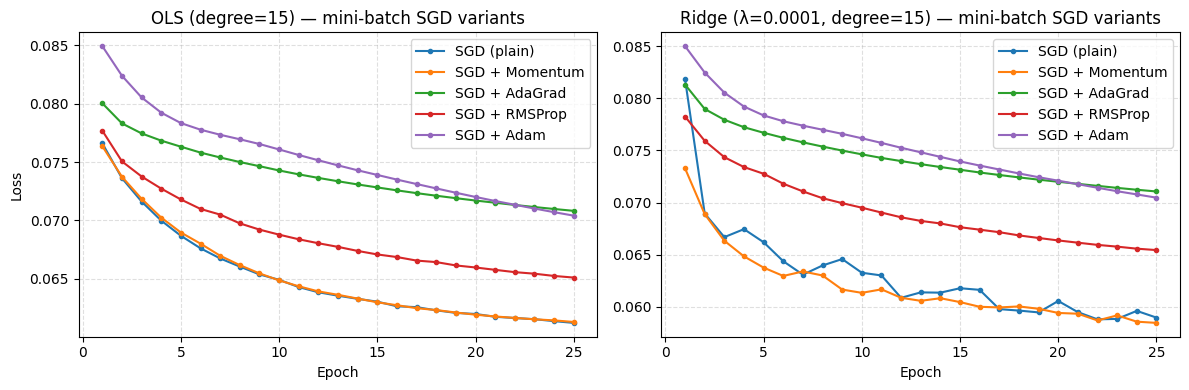

In [107]:
# ---- SGD variants of ALL optimizers (mini-batch for everyone) + schedules + nice logging ----
from math import pi, cos

# ---------- helpers ----------
def full_loss(X, y_c, theta, lam):
    from Code.grad import loss_ols, loss_ridge
    return float(loss_ols(X, y_c, theta)) if lam == 0.0 else float(loss_ridge(X, y_c, theta, lam, n_factor=True))

def ema(x, alpha=0.2):
    out, m = [], None
    for v in x:
        m = v if m is None else (1-alpha)*m + alpha*v
        out.append(m)
    return np.array(out)

def lr_schedule(step, *, eta0, total_steps=None, kind="constant"):
    """Return a scale in [0, eta0] for the given step and schedule kind."""
    if kind == "constant" or total_steps is None:
        return eta0
    if kind == "invtime":               # η_t = η0 / (1 + t)
        return eta0 / (1.0 + step)
    if kind == "cosine":                # half-cosine from η0 → 0 over total_steps
        t = min(step, total_steps)
        return 0.5 * eta0 * (1 + cos(pi * t / total_steps))
    raise ValueError(f"Unknown schedule: {kind}")

# curvature-aware baseline step for Ridge (we’ll shrink a bit for noisy mini-batches)
eigs_data = np.linalg.eigvalsh(XT_X_tr / n)
e_min, e_max = eigs_data[0], eigs_data[-1]
ETA_RIDGE_OPT = 2.0 / ((e_max + LAM) + (e_min + LAM))  # = 2/(L+mu)

def run_optimizer_lambda(
    X, y_c, lam, *, optimizer="sgd", eta=1e-3, epochs=25, batch_size=64,
    beta=BETA, rho=RHO, b1=B1, b2=B2, eps=EPS,
    schedule_kind="constant", rng=None, clip_grad=None, return_per_epoch=True
):
    """
    Mini-batch trainer for J(θ) = (1/2n)||Xθ-y||^2 + (λ/2)||θ||^2 (λ-form).
    - optimizer in {"sgd","momentum","adagrad","rmsprop","adam"}
    - schedule_kind in {"constant","invtime","cosine"}
    - returns (epochs_array, losses) if return_per_epoch else (steps_array, losses)
    """
    n, p = X.shape
    if rng is None:
        rng = np.random.default_rng(0)

    steps_per_epoch = int(np.ceil(n / batch_size))
    total_steps     = epochs * steps_per_epoch

    th = np.zeros(p)
    v  = np.zeros_like(th)  # momentum
    s  = np.zeros_like(th)  # 2nd moment (AdaGrad/RMSProp/Adam)
    m  = np.zeros_like(th)  # 1st moment (Adam)

    losses, xaxis = [], []
    step = 0
    for ep in range(1, epochs+1):
        perm = rng.permutation(n)
        for b in range(steps_per_epoch):
            step += 1
            lo, hi = b*batch_size, min((b+1)*batch_size, n)
            idx = perm[lo:hi]
            Xb, yb = X[idx], y_c[idx]
            nb = len(idx)

            # gradient (λ-form)
            g = (Xb.T @ (Xb @ th - yb))/nb + lam*th

            # optional gradient clipping
            if clip_grad is not None:
                gn = np.linalg.norm(g)
                if gn > clip_grad:
                    g *= (clip_grad / max(gn, 1e-12))

            # scheduled learning rate
            lr = lr_schedule(step, eta0=eta, total_steps=total_steps, kind=schedule_kind)

            # parameter update
            if optimizer == "sgd":
                th -= lr * g
            elif optimizer == "momentum":
                v  = beta*v + (1-beta)*g
                th -= lr * v
            elif optimizer == "adagrad":
                s += g*g
                th -= lr * g / (np.sqrt(s) + eps)
            elif optimizer == "rmsprop":
                s  = rho*s + (1-rho)*(g*g)
                th -= lr * g / (np.sqrt(s) + eps)
            elif optimizer == "adam":
                m  = b1*m + (1-b1)*g
                s  = b2*s + (1-b2)*(g*g)
                m_hat = m/(1-b1**step)
                s_hat = s/(1-b2**step)
                th -= lr * m_hat / (np.sqrt(s_hat) + eps)
            else:
                raise ValueError("unknown optimizer")

        # end-of-epoch clean log
        if return_per_epoch:
            losses.append(full_loss(X, y_c, th, lam))
            xaxis.append(ep)

    return th, np.array(xaxis), np.array(losses)

# ----- SGD setup & reporting knobs -----
rng = np.random.default_rng(SEED_MB)
STEPS_PER_EP = int(np.ceil(n / BATCH_SIZE))
ITERS_SGD    = EPOCHS_MB * STEPS_PER_EP  # total parameter updates

# schedules you can switch between: "constant", "invtime", "cosine"
SCHED = "constant"

# learning-rate choices (slightly conservative for mini-batch)
configs = {
    "sgd":      {"ols_eta0": 0.4 * eta_ols,      "ridge_eta0": 0.5 * ETA_RIDGE_OPT},
    "momentum": {"ols_eta0": 0.4 * eta_ols,      "ridge_eta0": 0.5 * ETA_RIDGE_OPT, "beta": BETA},
    "adagrad":  {"ols_eta0": 5e-3,               "ridge_eta0": 5e-3},
    "rmsprop":  {"ols_eta0": 1e-3,               "ridge_eta0": 1e-3, "rho": RHO},
    "adam":     {"ols_eta0": 1e-3,               "ridge_eta0": 1e-3, "b1": B1, "b2": B2, "eps": EPS},
}

# ----- run & collect -----
rows_ols, rows_ridge = [], []
curves_ols, curves_ridge = {}, {}

for name, hp in configs.items():
    # OLS (mini-batch)
    th_o, ep_o, ls_o = run_optimizer_lambda(
        Xtr_p, y_tr_c, lam=0.0, optimizer=name,
        eta=hp["ols_eta0"], epochs=EPOCHS_MB, batch_size=BATCH_SIZE,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS),
        schedule_kind=SCHED, rng=rng, clip_grad=None, return_per_epoch=True
    )
    yhat_o = predict_centered(Xte_p, th_o, y_mean)
    rows_ols.append((name, mse(y_te, yhat_o), r2(y_te, yhat_o)))
    curves_ols[name] = (ep_o, ls_o)

    # Ridge (mini-batch)
    th_r, ep_r, ls_r = run_optimizer_lambda(
        Xtr_p, y_tr_c, lam=LAM, optimizer=name,
        eta=hp["ridge_eta0"], epochs=EPOCHS_MB, batch_size=BATCH_SIZE,
        beta=hp.get("beta", BETA), rho=hp.get("rho", RHO),
        b1=hp.get("b1", B1), b2=hp.get("b2", B2), eps=hp.get("eps", EPS),
        schedule_kind=SCHED, rng=rng, clip_grad=None, return_per_epoch=True
    )
    yhat_r = predict_centered(Xte_p, th_r, y_mean)
    rows_ridge.append((name, mse(y_te, yhat_r), r2(y_te, yhat_r)))
    curves_ridge[name] = (ep_r, ls_r)

# ----- report “minimal knobs” clearly -----
print("\n--- Mini-batch training knobs ---")
print(f"Batch size:         {BATCH_SIZE}")
print(f"Epochs:             {EPOCHS_MB}")
print(f"Steps per epoch:    {STEPS_PER_EP}")
print(f"Total updates:      {ITERS_SGD}")
print(f"LR schedule:        {SCHED}")
print(f"Ridge λ:            {LAM}, degree p: {p}")

print("\nTEST metrics by optimizer (OLS, mini-batch)")
for name, m, r in rows_ols:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

print("\nTEST metrics by optimizer (Ridge, mini-batch)")
for name, m, r in rows_ridge:
    print(f"{name:9s}  MSE={m:.6f}  R²={r:.4f}")

# ---------- loss curves ----------
label_map = {
    "sgd": "SGD (plain)",
    "momentum": "SGD + Momentum",
    "adagrad": "SGD + AdaGrad",
    "rmsprop": "SGD + RMSProp",
    "adam": "SGD + Adam",
}
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

for name, (epochs_arr, losses) in curves_ols.items():
    axes[0].plot(epochs_arr, losses, marker="o", ms=3, label=label_map.get(name, name))
axes[0].set_title(f"OLS (degree={p}) — mini-batch SGD variants")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].grid(True, ls="--", alpha=0.4); axes[0].legend()

for name, (epochs_arr, losses) in curves_ridge.items():
    axes[1].plot(epochs_arr, losses, marker="o", ms=3, label=label_map.get(name, name))
axes[1].set_title(f"Ridge (λ={LAM:g}, degree={p}) — mini-batch SGD variants")
axes[1].set_xlabel("Epoch")
axes[1].grid(True, ls="--", alpha=0.4); axes[1].legend()

savepath = fig_dir / "Part_f_SGD_all_optimizers_loss_curves.png"
fig.savefig(savepath, dpi=150)
fig.tight_layout(); plt.show()
